# Fase 3: Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
BASE_PATH = "/content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva"
DATASET_PATH = os.path.join(BASE_PATH,'dataset_diagnosis.pkl')
dataset_diag = pd.read_pickle(DATASET_PATH)
dataset_diag.head()

,participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,scap,stopsignal,T1w,taskswitch,ScannerSerialNumber,ghost_NoGhost,path_dwi_file,path_dwi_acq,metadata_dwi
0,sub-10159,CONTROL,30,F,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost,/content/drive/MyDrive/root/UNAM/semestre9/min...,/content/drive/MyDrive/root/UNAM/semestre9/min...,"{'ImageType': 'ORIGINAL/PRIMARY/M/ND/MOSAIC', ..."
1,sub-10171,CONTROL,24,M,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost,/content/drive/MyDrive/root/UNAM/semestre9/min...,/content/drive/MyDrive/root/UNAM/semestre9/min...,"{'ImageType': 'ORIGINAL/PRIMARY/M/ND/MOSAIC', ..."
2,sub-10189,CONTROL,49,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost,/content/drive/MyDrive/root/UNAM/semestre9/min...,/content/drive/MyDrive/root/UNAM/semestre9/min...,"{'ImageType': 'ORIGINAL/PRIMARY/M/ND/MOSAIC', ..."
3,sub-10193,CONTROL,40,M,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35343.0,No_ghost,/content/drive/MyDrive/root/UNAM/semestre9/min...,/content/drive/MyDrive/root/UNAM/semestre9/min...,"{'ImageType': 'ORIGINAL/PRIMARY/M/ND/MOSAIC', ..."
4,sub-10206,CONTROL,21,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost,/content/drive/MyDrive/root/UNAM/semestre9/min...,/content/drive/MyDrive/root/UNAM/semestre9/min...,"{'ImageType': 'ORIGINAL/PRIMARY/M/ND/MOSAIC', ..."


De la fase 2 pudimos obtener un dataset que engloba todos nuestros registros. Lo consecuente es determinar y preparar los datos para un problema de clasificacion binaria como primer enfoque en donde cosideraremos a los pacientes como sanos(control) o no sanos.

In [ ]:
LABELS_CSV = os.path.join(BASE_PATH,'labels.csv')
dataset_diag['subject_id'] = dataset_diag['participant_id']
dataset_diag[['diagnosis','subject_id']].to_csv(LABELS_CSV,index=False)

In [ ]:
!pip install dipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 4.3 MB/s eta 0:00:00


# Características DWI

El pipeline implementado procesa volúmenes **DWI** para generar vectores de características basados en **Anisotropía Fraccional (FA)**.


## **1. Localización y validación de datos**
- Se buscan automáticamente todos los archivos **DWI** dentro de la carpeta base.
- Se vinculan con sus **etiquetas clínicas** (CONTROL, SCHZ, BIPOLAR, ADHD).
- Solo se procesan sujetos que cuentan con:
  - Archivo **DWI**
  - Archivos **bvals** y **bvecs**
  - **Etiqueta diagnóstica** válida



## **2. Filtros de calidad del volumen**
Para garantizar uniformidad entre sujetos:

- El volumen DWI debe ser **4D** con dimensiones exactas:  
  **96 × 96 × 50**
- Si **Z > 50**, se recortan los primeros slices.
- Si **Z < 50**, el sujeto se descarta.
- Se requieren al menos **65 canales** de difusión (incluyendo b0).
- Cualquier sujeto que no cumpla los criterios es descartado.


## **3. Enmascaramiento y control de calidad (QA)**
- Se genera una **máscara de cerebro** mediante `median_otsu`.
- Se crean imágenes de QA comparando:
  - **DWI crudo**
  - **DWI enmascarado**
- Estas imágenes permiten validar visualmente que el preprocesamiento es correcto.


## **4. Cálculo del mapa FA**
- A partir de `bvals` y `bvecs`, se construye un modelo de **tensor de difusión (DTI)**.
- Se calcula el mapa de **Anisotropía Fraccional (FA)** por voxel.
- Se reemplazan valores **NaN** y se normaliza el volumen FA para la siguiente etapa.



## **5. Normalización espacial**
- El primer sujeto válido se toma como **referencia espacial**.
- Los mapas FA de otros sujetos se **re-muestrean** a la misma cuadrícula para permitir comparaciones directas.



## **6. Extracción de características por bloques 3D**
- El volumen FA se divide en una **rejilla 3D de 8 × 8 × 8**, generando:
  - **512 bloques**
- Para cada bloque se calcula el **promedio FA**.
- El resultado es un vector de **512 características** por sujeto.



## **7. Construcción del dataset final**
Se genera un archivo CSV con las columnas:

- `subject_id`  
- `diagnosis`  
- `label_int`  
- `FA_BLOCK_000` … `FA_BLOCK_511`

Este dataset queda listo para entrenamiento y evaluación de modelos de clasificación (p. ej., SVM, Random Forest, MLP, etc.).



In [ ]:
OUTPUT_CSV  = os.path.join(BASE_PATH,'dwi_block_features_for_svm.csv')

In [ ]:
"""
Pipeline para extraer vectores de características a partir de volúmenes DWI,
sin usar atlas ni tractografía.

Incluye:
  - Filtro por dimensión espacial (96x96x50).
  - Manejo de volúmenes con Z > 50 recortando slices iniciales.
  - Descarte de volúmenes con Z < 50.
  - Descarte de volúmenes con menos de 65 canales (direcciones DWI).
  - Guardado de imágenes de QA en IMAGES/<subject_id>/:
        subject-id_zZZZ_chCCC.png
    (izquierda DWI crudo, derecha DWI enmascarado).

Salida:
  CSV con:
    subject_id, diagnosis, label_int, FA_BLOCK_000, ..., FA_BLOCK_N
"""

import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from nibabel.processing import resample_from_to
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel
from dipy.segment.mask import median_otsu

# ==========================
# CONFIGURACIÓN A EDITAR
# ==========================

OUTPUT_CSV  = os.path.join(BASE_PATH,'dwi_block_features_for_svm.csv')


# Carpeta donde se guardarán las imágenes de QA
IMAGES_FOLDER = os.path.join(BASE_PATH, "images")
os.makedirs(IMAGES_FOLDER, exist_ok=True)
# Rejilla de bloques 3D para promediar FA (total = Gx * Gy * Gz features)
GRID_DIMS = (8, 8, 8)   # 8x8x8 = 512 features

# Dimensión esperada del volumen DWI
EXPECTED_X = 96
EXPECTED_Y = 96
EXPECTED_Z = 50
MIN_VOLS   = 65   # mínimo de canales/volúmenes DWI

# Diccionario diagnóstico → entero
DIAG_TO_INT = {
    "CONTROL": 0,
    "SCHZ": 1,
    "BIPOLAR": 2,
    "ADHD": 3,
}


In [ ]:
# ==========================
# FUNCIONES AUXILIARES
# ==========================

def find_dwi_files(base_folder):
    pattern = os.path.join(base_folder, "**", "*dwi*.nii*")
    dwi_paths = glob.glob(pattern, recursive=True)

    subjects = {}
    for dwi_path in dwi_paths:
        rel = os.path.relpath(dwi_path, base_folder)
        parts = rel.split(os.sep)
        subject_id = parts[0]
        subjects[subject_id] = dwi_path

    return subjects


def infer_bvals_bvecs_paths(dwi_path):
    base = dwi_path
    if base.endswith(".gz"):
        base = base[:-3]
    if base.endswith(".nii"):
        base = base[:-4]

    bvals_path = base + ".bval"
    bvecs_path = base + ".bvec"

    if not os.path.exists(bvals_path):
        raise FileNotFoundError(f"No se encontró bvals: {bvals_path}")
    if not os.path.exists(bvecs_path):
        raise FileNotFoundError(f"No se encontró bvecs: {bvecs_path}")

    return bvals_path, bvecs_path


def load_labels(labels_csv):
    df = pd.read_csv(labels_csv)
    df["subject_id"] = df["subject_id"].astype(str).str.strip()
    df["diagnosis"]   = df["diagnosis"].astype(str).str.strip().str.upper()
    return dict(zip(df["subject_id"], df["diagnosis"]))


def save_debug_images(subject_id, data, masked_data, brain_mask,
                      ch_idx, images_base_dir, max_slices=10):
    """
    Guarda imágenes tipo QA para un sujeto:
      - 2 subplots por figura: DWI crudo vs DWI enmascarado.
      - Hasta max_slices niveles diferentes de Z.
      - Nombre: subject-id_zZZZ_chCCC.png
    """
    subj_dir = os.path.join(images_base_dir, subject_id)
    os.makedirs(subj_dir, exist_ok=True)

    _, _, sz, _ = data.shape
    # índices de Z (hasta 10, repartidos a lo largo del eje)
    z_indices = np.linspace(0, sz - 1, num=min(max_slices, sz), dtype=int)

    for z in z_indices:
        slice_raw    = data[:, :, z, ch_idx]
        slice_masked = masked_data[:, :, z, ch_idx]  # ya tiene fuera del cerebro a 0

        fig, axes = plt.subplots(1, 2, figsize=(6, 3))

        axes[0].imshow(slice_raw.T, cmap="gray", origin="lower")
        axes[0].set_title("Raw")
        axes[0].axis("off")

        axes[1].imshow(slice_masked.T, cmap="gray", origin="lower")
        axes[1].set_title("Masked")
        axes[1].axis("off")

        fig.tight_layout()

        fname = f"{subject_id}_z{int(z):03d}_ch{int(ch_idx):03d}.png"
        fpath = os.path.join(subj_dir, fname)
        fig.savefig(fpath, dpi=100, bbox_inches="tight")
        plt.close(fig)


def compute_fa_from_dwi_with_checks(subject_id, dwi_path, bvals_path, bvecs_path):
    """
    Carga DWI, aplica filtros de dimensión y nº de volúmenes,
    recorta en Z si es necesario, calcula FA y guarda imágenes de QA.
    Si el sujeto debe descartarse, devuelve None.
    """
    print(f"  > Cargando DWI: {dwi_path}")
    dwi_img = nib.load(dwi_path)
    data = dwi_img.get_fdata()
    affine = dwi_img.affine

    if data.ndim != 4:
        print("  ! Volumen no es 4D, se descarta.")
        return None

    sx, sy, sz, n_vols = data.shape
    print(f"  > Dimensiones originales: {sx}x{sy}x{sz}, volúmenes={n_vols}")

    # Comprobar nº de volúmenes
    if n_vols < MIN_VOLS:
        print(f"  ! Tiene menos de {MIN_VOLS} volúmenes ({n_vols}), se descarta.")
        return None

    # Comprobar X e Y
    if sx != EXPECTED_X or sy != EXPECTED_Y:
        print(f"  ! Dimensiones X,Y distintas de {EXPECTED_X}x{EXPECTED_Y}, se descarta.")
        return None

    # Manejo de Z
    if sz < EXPECTED_Z:
        print(f"  ! Tiene menos de {EXPECTED_Z} slices en Z ({sz}), se descarta.")
        return None
    elif sz > EXPECTED_Z:
        extra = sz - EXPECTED_Z
        print(f"  > Tiene Z={sz} > {EXPECTED_Z}, recortando {extra} slices iniciales.")
        data = data[:, :, extra:, :]
        sz = EXPECTED_Z
        affine = affine.copy()
        affine[:3, 3] = affine[:3, 3] + affine[:3, 2] * extra

    # Elegir canal a visualizar: primer b0 si existe, si no volumen 0
    bvals = np.loadtxt(bvals_path)
    bvecs = np.loadtxt(bvecs_path)
    gtab  = gradient_table(bvals, bvecs)

    b0_idx = np.where(bvals < 50)[0]
    if b0_idx.size > 0:
        ch_idx = int(b0_idx[0])
    else:
        ch_idx = 0
    print(f"  > Canal elegido para QA: {ch_idx}")

    print("  > Estimando máscara de cerebro (median_otsu)...")
    n_vols_mask = min(10, data.shape[-1])
    masked_data, brain_mask = median_otsu(
        data,
        vol_idx=list(range(n_vols_mask)),
        median_radius=3,
        numpass=1
    )

    # Guardar imágenes de QA
    try:
        save_debug_images(subject_id, data, masked_data, brain_mask,
                          10, IMAGES_FOLDER, max_slices=10)
    except Exception as e:
        print(f"  ! Error al guardar imágenes de QA: {e}")

    print("  > Ajustando modelo de tensor (DTI)...")
    tenmodel = TensorModel(gtab)
    tenfit   = tenmodel.fit(masked_data, mask=brain_mask)

    fa = tenfit.fa
    fa = np.nan_to_num(fa)

    fa_img = nib.Nifti1Image(fa, affine)
    return fa_img


def resample_to_reference(img, ref_img):
    return resample_from_to(img, ref_img)


def compute_block_features(fa_img, grid_dims=(8, 8, 8)):
    fa = fa_img.get_fdata()
    sx, sy, sz = fa.shape
    gx, gy, gz = grid_dims

    x_edges = np.linspace(0, sx, gx + 1, dtype=int)
    y_edges = np.linspace(0, sy, gy + 1, dtype=int)
    z_edges = np.linspace(0, sz, gz + 1, dtype=int)

    features = []
    for ix in range(gx):
        xs, xe = x_edges[ix], x_edges[ix + 1]
        for iy in range(gy):
            ys, ye = y_edges[iy], y_edges[iy + 1]
            for iz in range(gz):
                zs, ze = z_edges[iz], z_edges[iz + 1]
                block = fa[xs:xe, ys:ye, zs:ze]
                vals  = block[block > 0]
                if vals.size == 0:
                    features.append(0.0)
                else:
                    features.append(float(vals.mean()))
    return features


print(f"Cargando etiquetas desde: {LABELS_CSV}")
labels_dict = load_labels(LABELS_CSV)

print(f"Buscando DWIs en: {BASE_PATH}")
subj_to_dwi = find_dwi_files(BASE_PATH)
print(f"Se encontraron {len(subj_to_dwi)} sujetos con DWI.\n")

all_features   = []
all_labels_int = []
all_subject_ids = []
all_diag_str   = []

ref_fa_img = None

for idx, (subj_id, dwi_path) in enumerate(sorted(subj_to_dwi.items())):
    print(f"\nProcesando sujeto ({idx+1}/{len(subj_to_dwi)}): {subj_id}")

    if subj_id not in labels_dict:
        print(f"  ! No hay etiqueta para {subj_id}, se omite.")
        continue

    diag_str = labels_dict[subj_id].upper()
    if diag_str not in DIAG_TO_INT:
        print(f"  ! Diagnóstico {diag_str} no está en DIAG_TO_INT, se omite.")
        continue

    label_int = DIAG_TO_INT[diag_str]

    try:
        bvals_path, bvecs_path = infer_bvals_bvecs_paths(dwi_path)
    except FileNotFoundError as e:
        print("  !", e)
        continue

    fa_img_native = compute_fa_from_dwi_with_checks(
        subj_id, dwi_path, bvals_path, bvecs_path
    )
    if fa_img_native is None:
        continue

    if ref_fa_img is None:
        print("  > Usando este sujeto como referencia (rejilla base).")
        ref_fa_img = fa_img_native

    if fa_img_native.shape != ref_fa_img.shape:
        print("  > Re-muestreando FA al espacio de referencia...")
        fa_img = resample_to_reference(fa_img_native, ref_fa_img)
    else:
        fa_img = fa_img_native

    print("  > Calculando features por bloques 3D...")
    feats = compute_block_features(fa_img, GRID_DIMS)

    all_features.append(feats)
    all_labels_int.append(label_int)
    all_subject_ids.append(subj_id)
    all_diag_str.append(diag_str)

print("\nConstruyendo DataFrame de características...")

gx, gy, gz = GRID_DIMS
n_blocks = gx * gy * gz
col_names = [f"FA_BLOCK_{i:03d}" for i in range(n_blocks)]

df_feats = pd.DataFrame(all_features, columns=col_names)
df_feats.insert(0, "subject_id", all_subject_ids)
df_feats["diagnosis"] = all_diag_str
df_feats["label_int"] = all_labels_int

print(f"Guardando features en: {OUTPUT_CSV}")
df_feats.to_csv(OUTPUT_CSV, index=False)

print("Listo. Sujetos procesados:", len(df_feats))




Cargando etiquetas desde: /content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/labels.csv
Buscando DWIs en: /content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva


KeyboardInterrupt: 

In [ ]:
df_feats = pd.read_csv(OUTPUT_CSV)
df_feats.head()

,subject_id,FA_BLOCK_000,FA_BLOCK_001,FA_BLOCK_002,FA_BLOCK_003,FA_BLOCK_004,FA_BLOCK_005,FA_BLOCK_006,FA_BLOCK_007,FA_BLOCK_008,...,FA_BLOCK_504,FA_BLOCK_505,FA_BLOCK_506,FA_BLOCK_507,FA_BLOCK_508,FA_BLOCK_509,FA_BLOCK_510,FA_BLOCK_511,diagnosis,label_int
0,sub-10159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0
1,sub-10171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0
2,sub-10189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0
3,sub-10193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0
4,sub-10206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0


# **Características FA (Fractional Anisotropy) y su Interpretación Matemática**

Las características FA utilizadas en este pipeline provienen del modelo de **Tensor de Difusión (DTI)**, el cual describe cómo se difunden las moléculas de agua en el cerebro. La Anisotropía Fraccional (FA) es una medida derivada del tensor que cuantifica qué tan direccional es la difusión en cada voxel.


# **1. ¿Qué es la Anisotropía Fraccional (FA)?**

La **FA** es un valor escalar entre **0 y 1** que resume la forma del tensor de difusión:

- **FA ≈ 0** → difusión isotrópica (igual en todas las direcciones), típica en:
  - Sustancia gris
  - Líquido cefalorraquídeo  
- **FA ≈ 1** → difusión altamente anisotrópica (predominio de una dirección), típica en:
  - Sustancia blanca
  - Fascículos bien organizados

Esto convierte la información direccional compleja del tensor en una **medida compacta, estable y neuroanatómicamente interpretable**.


# **2. Modelo matemático del tensor de difusión**

El tensor de difusión **D** es una matriz simétrica 3×3:

$$
D=
\begin{bmatrix}
D_{xx} & D_{xy} & D_{xz} \\
D_{xy} & D_{yy} & D_{yz} \\
D_{xz} & D_{yz} & D_{zz}
\end{bmatrix}
$$

Este tensor se obtiene ajustando el modelo DTI sobre los datos DWI mediante:

$$
S(b, \mathbf{g}) = S_0 \exp\left( -b \, \mathbf{g}^T D \mathbf{g} \right)
$$

donde:

- $ S(b, \mathbf{g}) $ → intensidad medida  
- $ b$ → valor b del volumen  
- $ \mathbf{g} $ → dirección de gradiente  
- $ S_0 $ → imagen b0  

El ajustador (TensorModel en DIPY) estima los 6 parámetros independientes del tensor.



# **3. Obtención de autovalores**

Una vez estimado el tensor, se realiza su **descomposición espectral**:

$
D = V \Lambda V^{-1}
$

donde:

- $ \Lambda = \text{diag}(\lambda_1, \lambda_2, \lambda_3) $
- $ \lambda_1 \geq \lambda_2 \geq \lambda_3 $ son los **autovalores** que representan la magnitud de la difusión en las direcciones principales.


# **4. Cálculo matemático de la FA**

La FA se define como:

$$
FA = \sqrt{\frac{3}{2}}
\frac{\sqrt{
(\lambda_1 - \bar{\lambda})^2 +
(\lambda_2 - \bar{\lambda})^2 +
(\lambda_3 - \bar{\lambda})^2}}
{\sqrt{\lambda_1^2 + \lambda_2^2 + \lambda_3^2}}
$$

donde:

$$
\bar{\lambda} = \frac{\lambda_1 + \lambda_2 + \lambda_3}{3}
$$

En palabras simples:

- El **numerador** mide qué tan distintos son los autovalores (anisotropía).
- El **denominador** normaliza por la magnitud del tensor.

# **5. Conversión a características (FA Blocks)**

Una vez obtenido el volumen FA (3D), se aplica el siguiente procedimiento para convertirlo en un **vector de características**:

### **Paso 1: Normalización espacial**
Todos los volúmenes FA se llevan a una misma cuadrícula mediante re‑muestreo.

### **Paso 2: División en una rejilla 3D (8×8×8)**
El volumen FA se divide en bloques cúbicos uniformes:


8 \times 8 \times 8 = 512 \text{ bloques}


Cada bloque contiene una porción distinta del volumen FA.

### **Paso 3: Promedio de FA por bloque**
Para cada bloque:

$$
f_i = \frac{1}{N_i} \sum_{v \in \text{bloque}_i} FA(v)
$$

donde:

- $ f_i $ → característica del bloque i  
- $ N_i $ → número de voxels con FA > 0  
- $FA(v)$ → valor de FA del voxel v  

### **Resultado**
Cada sujeto se representa mediante un **vector fijo de 512 características**:

$$
\mathbf{f} = [f_1, f_2, \dots, f_{512}]
$$

Este vector resume la **distribución espacial de la anisotropía** sin requerir registro avanzado ni tractografía.


# **6. Interpretación final**

Los vectores FA resultantes:

- Capturan **patrones microestructurales** de la sustancia blanca.
- Son robustos ante ruido, diferencias de alineamiento y variabilidad anatómica.
- Permiten comparar sujetos en un espacio numérico uniforme.
- Son adecuados para modelos tradicionales como:
  - SVM
  - Random Forest
  - Logistic Regression
  - Redes densas pequeñas

---


In [ ]:
import numpy as np



df_feats['label_bin'] = df_feats['label_int'].apply(lambda x: 1 if x > 0 else 0)
x1 = df_feats[df_feats['label_bin'] == 1].filter(like="FA_BLOCK_").values
x1 = np.mean(x1, axis=0)
x0 = df_feats[df_feats['label_bin'] == 0].filter(like="FA_BLOCK_").values
x0 = np.mean(x0, axis=0)


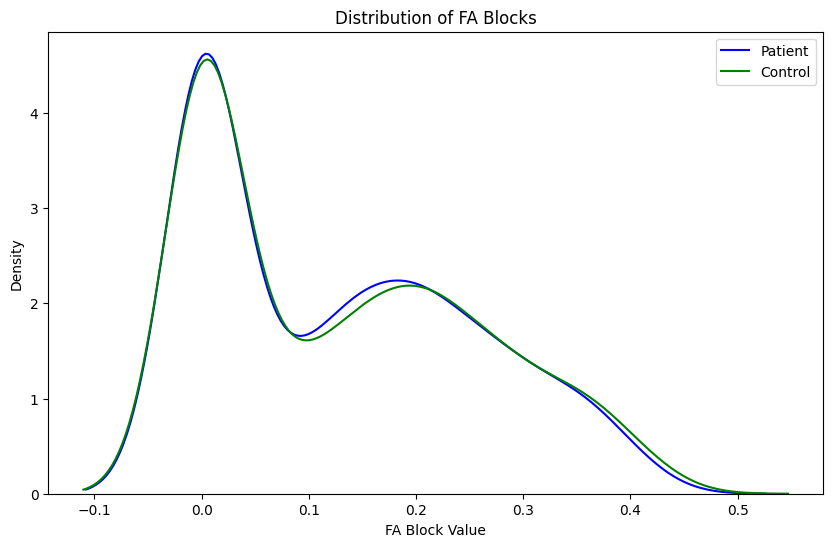

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#distribucion
plt.figure(figsize=(10, 6))
sns.kdeplot(x1, label='Patient', color='blue')
sns.kdeplot(x0, label='Control', color='green')
plt.title('Distribution of FA Blocks')
plt.xlabel('FA Block Value')
plt.ylabel('Density')
plt.legend()
plt.show()

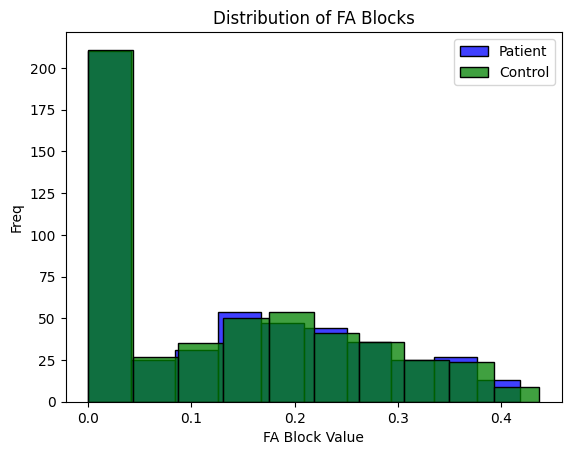

In [ ]:
sns.histplot(x1, label='Patient', color='blue')
sns.histplot(x0, label='Control', color='green')
plt.title('Distribution of FA Blocks')
plt.xlabel('FA Block Value')
plt.ylabel('Freq')
plt.legend()

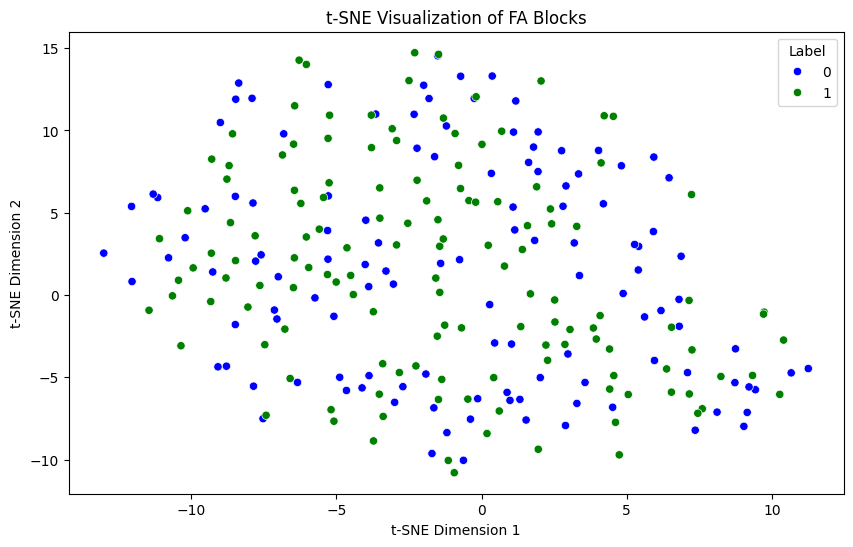

In [ ]:
#tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X = df_feats.filter(like="FA_BLOCK_").values
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_feats['label_bin'], palette=['blue', 'green'])
plt.title('t-SNE Visualization of FA Blocks')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Label')
plt.show()

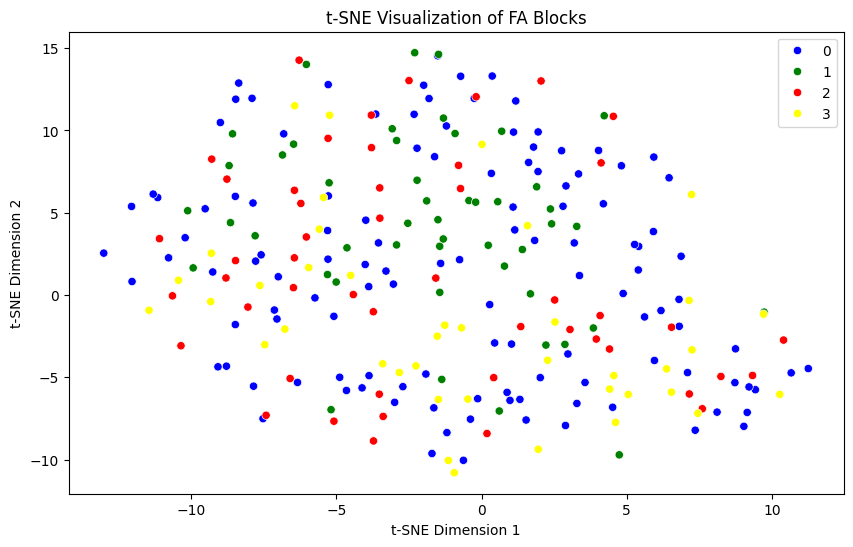

In [ ]:
#tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X = df_feats.filter(like="FA_BLOCK_").values
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_feats['label_int'], palette=['blue', 'green','red','yellow'])
plt.title('t-SNE Visualization of FA Blocks')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

Consideramos que estas caracteristicas que intentan simplificar sin embargo no ayudan a separar entre las clases

Varianza explicada por cada componente: [0.17816501 0.11258423]


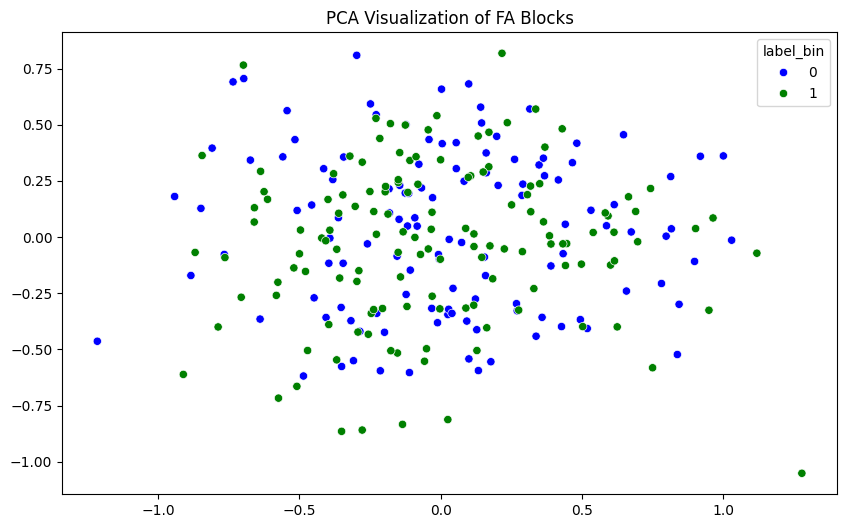

In [ ]:
#pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
varianza_explicada = pca.explained_variance_ratio_
print(f"Varianza explicada por cada componente: {varianza_explicada}")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_feats['label_bin'], palette=['blue', 'green'])
plt.title('PCA Visualization of FA Blocks')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

df = pd.read_csv(OUTPUT_CSV)
display(df.head())
X = df.filter(like="FA_BLOCK_").values  # features
df['label_bin'] = df['label_int'].apply(lambda x: 1 if x > 0 else 0)
y = df["label_bin"].values              # etiquetas numéricas

# 2. Definir pipeline SVM
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        class_weight="balanced"
    ))
])

# 3. Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="balanced_accuracy")

print("Balanced accuracy por fold:", scores)
print("Balanced accuracy media:", scores.mean())

,subject_id,FA_BLOCK_000,FA_BLOCK_001,FA_BLOCK_002,FA_BLOCK_003,FA_BLOCK_004,FA_BLOCK_005,FA_BLOCK_006,FA_BLOCK_007,FA_BLOCK_008,...,FA_BLOCK_504,FA_BLOCK_505,FA_BLOCK_506,FA_BLOCK_507,FA_BLOCK_508,FA_BLOCK_509,FA_BLOCK_510,FA_BLOCK_511,diagnosis,label_int
0,sub-10159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0
1,sub-10171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0
2,sub-10189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0
3,sub-10193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0
4,sub-10206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONTROL,0


Balanced accuracy por fold: [0.72592593 0.62202381 0.57738095 0.60185185 0.60185185]
Balanced accuracy media: 0.6258068783068783


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(OUTPUT_CSV)

# Define the target vector y (Binary: 1 for Patient, 0 for Control)
y = df['label_int'].apply(lambda x: 1 if x > 0 else 0).values

# Define the feature matrix X (Select columns starting with "FA_BLOCK_")
X = df.filter(like="FA_BLOCK_").values

# Split the data into training (90%) and testing (10%) sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (232, 512)
X_test shape: (26, 512)
y_train shape: (232,)
y_test shape: (26,)


# Dwi Files

In [ ]:
pip install psutil tqdm

In [ ]:
import os
import glob
import pickle
import random

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm.auto import tqdm

In [ ]:
# ==========================
# CONFIGURACIÓN
# ==========================

BASE_FOLDER = "/content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva"
LABELS_CSV = "/content/drive/MyDrive/root/UNAM/semestre9/mineria-masiva/labels.csv"

OUT_FOLDER = os.path.join(BASE_FOLDER, "out")
DATA_FOLDER = os.path.join(OUT_FOLDER, "data")
os.makedirs(OUT_FOLDER, exist_ok=True)
os.makedirs(DATA_FOLDER, exist_ok=True)

MANIFEST_PATH = os.path.join(DATA_FOLDER, "manifest.csv")

EXPECTED_X = 96
EXPECTED_Y = 96
TARGET_Z   = 50

MIN_CHANNELS_TOTAL = 65   # incluye canal 0 (b0)
DIFF_CHANNELS      = 64   # canales de difusión usados (1..64)


BLOCK_FRACTION = 0.2  # cada bloque ~20% de los sujetos válidos

# Mapeo binario: 0 = control sano, 1 = paciente (cualquier diagnóstico)
DIAG_TO_INT = {
    "CONTROL": 0,
    "SCHZ": 1,
    "BIPOLAR": 1,
    "ADHD": 1,
}


## Descripción del data featuring

El código implementa un pipeline para **descubrir sujetos válidos**, **preprocesar sus volúmenes DWI** y **exportarlos en bloques** listos para entrenar redes 3D.

### 1. Búsqueda de datos y etiquetas

- `find_dwi_files(base_folder)`:
  - Recorre la carpeta base y subcarpetas.
  - Busca archivos `*dwi*.nii*`.
  - Asume estructura `base_folder/sub-XXXX/.../algo_dwi.nii.gz`.
  - Devuelve un diccionario `{subject_id: ruta_dwi}`.

- `load_labels(labels_csv)`:
  - Lee un `labels.csv` con columnas `subject_id, diagnosis`.
  - Normaliza cadenas (strip, upper).
  - Devuelve `{subject_id: diagnosis_str}`.

### 2. Preprocesamiento del volumen DWI

- `quick_check_shape(path)`:
  - Carga solo la cabecera NIfTI.
  - Devuelve la forma `(X, Y, Z, C)` para hacer filtros rápidos sin leer todo el volumen.

- `load_and_preprocess_dwi(path)`:
  - Carga el DWI completo (`get_fdata()`).
  - Verifica que:
    - Sea 4D: `(X, Y, Z, C)`.
    - `X` y `Y` coincidan con `EXPECTED_X, EXPECTED_Y`.
    - `Z >= TARGET_Z`; si `Z > TARGET_Z` recorta slices iniciales hasta `TARGET_Z`.
    - `C >= MIN_CHANNELS_TOTAL`.
  - Elimina el **canal 0 (b0)** y utiliza solo los canales de difusión `1..DIFF_CHANNELS`.
  - Aplica **normalización z-score** sobre voxels > 0:
    - Resta la media y divide entre la desviación estándar del volumen.
  - Reordena a formato **(C, D, H, W)** (canales, z, y, x).
  - Devuelve un tensor `float32` listo para entrar a una CNN 3D.

### 3. Descubrimiento de candidatos

- `discover_candidates(base_folder, labels_csv)`:
  - Carga etiquetas (`load_labels`) y rutas DWI (`find_dwi_files`).
  - Filtra sujetos que tengan:
    - DWI presente.
    - Diagnóstico mapeable en `DIAG_TO_INT`.
  - Devuelve lista de tuplas:
    - `(subject_id, path_dwi, label_int)`.

### 4. Exportación en bloques (para no saturar RAM)

- `export_blocks_and_manifest(candidates, block_fraction=0.2)`:
  - Recorre todos los candidatos.
  - Para cada uno:
    - Llama a `load_and_preprocess_dwi(path)` → tensor (C, D, H, W).
    - Acumula volúmenes, etiquetas e IDs en listas temporales.
  - Cuando se alcanza el tamaño de bloque (~20 % del total):
    - Guarda un `block_XXX.pkl` en `DATA_FOLDER` con:
      - `"volumes"`: lista de tensores preprocesados.
      - `"labels"`: lista de labels enteros.
      - `"subject_ids"`: lista de IDs de sujeto.
    - Registra en una bitácora (`manifest_rows`) para cada sujeto:
      - `global_index`, `subject_id`, `label`, `block_id`, `index_in_block`.
  - Al final:
    - Guarda bloque residual si quedó incompleto.
    - Exporta `manifest.csv` con la bitácora completa.

### 5. Reconstrucción para entrenamiento

- `list_block_files()`:
  - Devuelve la lista ordenada de `block_XXX.pkl` en `DATA_FOLDER`.

- `load_all_blocks_to_ram()`:
  - Carga todos los bloques `block_XXX.pkl`.
  - Concatena `"volumes"` y `"labels"` de cada bloque.
  - Devuelve:
    - `all_volumes`: lista de tensores (C, D, H, W) preprocesados.
    - `all_labels`: lista de etiquetas enteras.

En resumen, el **data featuring** consiste en:
1. Encontrar y etiquetar sujetos.
2. Preprocesar cada DWI a un tensor normalizado `(C, D, H, W)` (sin canal b0).
3. Guardar estos tensores y sus etiquetas en **bloques pickle** + un `manifest.csv`.
4. Volver a cargar todos los bloques en RAM como dataset de entrada para la CNN 3D.


In [ ]:
# ==========================
# UTILIDADES DE CARGA
# ==========================

def find_dwi_files(base_folder):
    """
    Busca archivos *dwi*.nii* en subcarpetas de base_folder.
    Asume estructura base_folder/sub-XXXX/.../algo_dwi.nii.gz
    Devuelve dict {subject_id: path_dwi}
    """
    pattern = os.path.join(base_folder, "**", "*dwi*.nii*")
    dwi_paths = glob.glob(pattern, recursive=True)

    subjects = {}
    for dwi_path in dwi_paths:
        rel = os.path.relpath(dwi_path, base_folder)
        parts = rel.split(os.sep)
        subject_id = parts[0]
        subjects[subject_id] = dwi_path

    return subjects


def load_labels(labels_csv):
    """
    Lee labels.csv con columnas: subject_id, diagnosis
    y devuelve dict {subject_id: diagnosis_str}
    """
    df = pd.read_csv(labels_csv)
    df["subject_id"] = df["subject_id"].astype(str).str.strip()
    df["diagnosis"] = df["diagnosis"].astype(str).str.strip().str.upper()
    return dict(zip(df["subject_id"], df["diagnosis"]))


def quick_check_shape(path):
    """
    Carga solo cabecera para revisar shape (X,Y,Z,C) sin leer todo el volumen.
    Devuelve shape o None si hay problema.
    """
    try:
        img = nib.load(path)
        return img.shape
    except Exception as e:
        print(f"  ! Error cargando cabecera de {path}: {e}")
        return None


def load_and_preprocess_dwi(path):
    """
    Carga un DWI (NIfTI) y aplica reglas de shape/canales:

      - Espera data 4D (X,Y,Z,C).
      - X,Y deben ser EXPECTED_X, EXPECTED_Y.
      - Si Z < TARGET_Z -> descarta (return None).
      - Si Z > TARGET_Z -> recorta slices iniciales en Z.
      - Si C < MIN_CHANNELS_TOTAL -> descarta.
      - Elimina canal 0 (b0) y usa canales 1..(1+DIFF_CHANNELS-1).
      - Normaliza z-score sobre voxels > 0.
      - Reordena a (C, D, H, W).

    Devuelve:
      tensor float32 de shape (C, D, H, W)
      o None si el volumen se descarta.
    """
    img = nib.load(path)
    data = img.get_fdata()  # (X,Y,Z,C)

    if data.ndim != 4:
        print(f"  ! {path}: no es 4D, se descarta.")
        return None

    x, y, z, c = data.shape

    if x != EXPECTED_X or y != EXPECTED_Y:
        print(f"  ! {path}: XY={x}x{y} distinto de {EXPECTED_X}x{EXPECTED_Y}, se descarta.")
        return None

    if z < TARGET_Z:
        print(f"  ! {path}: Z={z} < {TARGET_Z}, se descarta.")
        return None
    elif z > TARGET_Z:
        extra = z - TARGET_Z
        data = data[:, :, extra:, :]
        z = TARGET_Z

    if c < MIN_CHANNELS_TOTAL:
        print(f"  ! {path}: C={c} < {MIN_CHANNELS_TOTAL}, se descarta.")
        return None

    # quitamos canal 0 (b0) y tomamos DIFF_CHANNELS canales de difusión
    start_ch = 1
    end_ch = start_ch + DIFF_CHANNELS  # 1..64
    if end_ch > c:
        print(f"  ! {path}: tras quitar canal 0 no hay {DIFF_CHANNELS} canales de difusión, se descarta.")
        return None

    data = data[:, :, :, start_ch:end_ch]  # (X,Y,Z,DIFF_CHANNELS)

    # Normalización z-score sobre voxels > 0
    mask = data > 0
    if np.any(mask):
        mean = data[mask].mean()
        std = data[mask].std()
        if std > 0:
            data = (data - mean) / std
        else:
            data = data - mean
    else:
        print(f"  ! {path}: todos los voxels son 0 tras recorte, se descarta.")
        return None

    # Reordenar a (C, D, H, W) → (chan, z, y, x)
    data = np.transpose(data, (3, 2, 1, 0)).astype(np.float32)

    return torch.from_numpy(data)

# ==========================
# CANDIDATOS + EXPORT POR BLOQUES
# ==========================

def discover_candidates(base_folder, labels_csv):
    """
    Descubre sujetos candidatos (por shape básico) SIN cargar el volumen completo.
    Devuelve lista de (subject_id, path, label_int).
    """
    labels_dict = load_labels(labels_csv)
    subject_to_path = find_dwi_files(base_folder)

    candidates = []

    for subj_id, path in subject_to_path.items():
        if subj_id not in labels_dict:
            continue

        diag_str = labels_dict[subj_id].upper()
        if diag_str not in DIAG_TO_INT:
            continue

        label_int = DIAG_TO_INT[diag_str]

        candidates.append((subj_id, path, label_int))

    print(f"Total sujetos candidatos (por shape/canales mínimos): {len(candidates)}")
    return candidates


def export_blocks_and_manifest(candidates, block_fraction=0.2):
    """
    Recorre la lista de candidatos, carga+preprocesa cada volumen y
    los va guardando en bloques (~20% del total) para no explotar la RAM
    al hacer un pickle gigante.

    - Exporta:
        data/block_000.pkl, block_001.pkl, ...
        Cada bloque tiene: dict(volumes, labels, subject_ids)
    - Crea manifest.csv con columnas:
        global_index, subject_id, label, block_id, index_in_block
    """
    if len(candidates) == 0:
        raise RuntimeError("No hay candidatos para exportar bloques.")

    block_size = max(1, int(len(candidates) * block_fraction))
    print(f"Usando block_size={block_size} (~{block_fraction*100:.0f}% de {len(candidates)})")

    block_id = 0
    current_vols = []
    current_labels = []
    current_subjs = []

    manifest_rows = []
    global_index = 0

    for subj_id, path, label_int in tqdm(candidates, desc="Procesando y exportando bloques", unit="subject"):
        vol = load_and_preprocess_dwi(path)
        if vol is None:
            continue

        # índice dentro del bloque actual
        index_in_block = len(current_vols)

        current_vols.append(vol)
        current_labels.append(label_int)
        current_subjs.append(subj_id)

        # fila de bitácora
        manifest_rows.append({
            "global_index": global_index,
            "subject_id": subj_id,
            "label": label_int,
            "block_id": block_id,
            "index_in_block": index_in_block
        })
        global_index += 1

        # si el bloque llegó al tamaño, lo guardamos y limpiamos buffers
        if len(current_vols) >= block_size:
            block_path = os.path.join(DATA_FOLDER, f"block_{block_id:03d}.pkl")
            with open(block_path, "wb") as f:
                pickle.dump({
                    "volumes": current_vols,
                    "labels": current_labels,
                    "subject_ids": current_subjs,
                }, f)
            print(f"  -> Guardado bloque {block_id} con {len(current_vols)} sujetos en {block_path}")

            block_id += 1
            current_vols = []
            current_labels = []
            current_subjs = []

    # guardar bloque final (si quedó algo)
    if len(current_vols) > 0:
        block_path = os.path.join(DATA_FOLDER, f"block_{block_id:03d}.pkl")
        with open(block_path, "wb") as f:
            pickle.dump({
                "volumes": current_vols,
                "labels": current_labels,
                "subject_ids": current_subjs,
            }, f)
        print(f"  -> Guardado bloque final {block_id} con {len(current_vols)} sujetos en {block_path}")

    # guardar manifest
    df_manifest = pd.DataFrame(manifest_rows)
    df_manifest.to_csv(MANIFEST_PATH, index=False)
    print(f"Bitácora guardada en {MANIFEST_PATH}")
    print(f"Total sujetos válidos exportados: {len(manifest_rows)}")


def list_block_files():
    """
    Devuelve lista ordenada de paths a bloques block_XXX.pkl
    """
    pattern = os.path.join(DATA_FOLDER, "block_*.pkl")
    files = sorted(glob.glob(pattern))
    return files

def load_all_blocks_to_ram():
    """
    Carga TODOS los bloques block_XXX.pkl a RAM y devuelve:
      volumes: lista de tensores (C,D,H,W)
      labels : lista de ints
    (Los subject_ids se guardan en los bloques y en manifest.csv,
     pero para entrenamiento sólo necesitamos volumes+labels.)
    """
    block_files = list_block_files()
    if not block_files:
        raise RuntimeError("No hay bloques block_*.pkl en data/. Primero ejecuta export_blocks_and_manifest.")

    all_volumes = []
    all_labels = []

    print("Cargando todos los bloques a RAM...")
    for block_path in tqdm(block_files, desc="Cargando bloques", unit="block"):
        with open(block_path, "rb") as f:
            data = pickle.load(f)
        vols_b = data["volumes"]
        labels_b = data["labels"]
        all_volumes.extend(vols_b)
        all_labels.extend(labels_b)

    print(f"Total sujetos cargados desde bloques: {len(all_volumes)}")
    return all_volumes, all_labels

## Hyperparameter Optimization



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
# Create a pipeline with scaling and SVM
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("svm", SVC(class_weight="balanced"))
])

# Define the parameter grid
param_grid = {
    "svm__kernel": ["rbf", "linear"],
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", "auto", 0.01, 0.1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1  # Use all available cores
)

# Fit the model on the training data
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

# Display the best parameters and score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best balanced accuracy: {grid_search.best_score_:.4f}")

# Save the best model
best_model = grid_search.best_estimator_

Starting Grid Search...
Best hyperparameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best balanced accuracy: 0.5695
